In [1]:
import pandas as pd
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx
import geoplot as gplt
import lightgbm as lgb
import eli5
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import cm
from shapely.geometry import  Point
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

Using TensorFlow backend.


In [2]:
full_data = pd.read_csv('./Chicago_Crimes_2012_to_2017.csv',index_col ='ID',parse_dates=['Date'])
full_data.dtypes

Unnamed: 0                       int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
dtype: object

In [3]:
full_data['Date'] = pd.to_datetime(full_data['Date'],format='%Y-%m-%d %H:%M:%S')
full_data.head(5)

,Unnamed: 0,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
ID,,,,,,,,,,,,,,,,,,,,,
10508693,3,HZ250496,2016-05-03 23:40:00,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
10508695,89,HZ250409,2016-05-03 21:40:00,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
10508697,197,HZ250503,2016-05-03 23:31:00,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
10508698,673,HZ250424,2016-05-03 22:10:00,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
10508699,911,HZ250455,2016-05-03 22:00:00,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,True,...,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


In [4]:
full_data['Dates'] =full_data['Date']
full_data['Hour'] =full_data['Date'].dt.hour
full_data['Date'] =full_data['Date'].dt.date

In [5]:
#print('First date: ', str(full_data.Dates.describe()))
#print('Last date: ', str(full_data.Dates.describe()['last']))
print('Full data shape ', full_data.shape)
full_data.dtypes

Full data shape  (1456714, 24)


Unnamed: 0                       int64
Case Number                     object
Date                            object
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
Dates                   datetime64[ns]
Hour                             int64
dtype: object

In [6]:
full_data.duplicated().sum()

0

In [7]:
#결측값 제거
full_data = full_data.dropna(axis=0)
full_data.head(5)

,Unnamed: 0,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Dates,Hour
ID,,,,,,,,,,,,,,,,,,,,,
10508693,3,HZ250496,2016-05-03,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)",2016-05-03 23:40:00,23
10508695,89,HZ250409,2016-05-03,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)",2016-05-03 21:40:00,21
10508697,197,HZ250503,2016-05-03,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,...,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)",2016-05-03 23:31:00,23
10508698,673,HZ250424,2016-05-03,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,...,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)",2016-05-03 22:10:00,22
10508699,911,HZ250455,2016-05-03,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,True,...,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)",2016-05-03 22:00:00,22


In [8]:
full_data['Primary Type'].unique()

array(['BATTERY', 'PUBLIC PEACE VIOLATION', 'THEFT', 'WEAPONS VIOLATION',
       'ROBBERY', 'MOTOR VEHICLE THEFT', 'ASSAULT', 'OTHER OFFENSE',
       'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS',
       'BURGLARY', 'STALKING', 'CRIM SEXUAL ASSAULT', 'NARCOTICS',
       'SEX OFFENSE', 'HOMICIDE', 'OFFENSE INVOLVING CHILDREN',
       'INTERFERENCE WITH PUBLIC OFFICER', 'PROSTITUTION', 'KIDNAPPING',
       'GAMBLING', 'INTIMIDATION', 'ARSON', 'LIQUOR LAW VIOLATION',
       'OBSCENITY', 'NON-CRIMINAL', 'PUBLIC INDECENCY',
       'HUMAN TRAFFICKING', 'CONCEALED CARRY LICENSE VIOLATION',
       'NON - CRIMINAL', 'OTHER NARCOTIC VIOLATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

In [9]:
from sklearn import preprocessing
input_labels = ['BATTERY', 'PUBLIC PEACE VIOLATION', 'THEFT', 'WEAPONS VIOLATION',
       'ROBBERY', 'MOTOR VEHICLE THEFT', 'ASSAULT', 'OTHER OFFENSE',
       'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS',
       'BURGLARY', 'STALKING', 'CRIM SEXUAL ASSAULT', 'NARCOTICS',
       'SEX OFFENSE', 'HOMICIDE', 'OFFENSE INVOLVING CHILDREN',
       'INTERFERENCE WITH PUBLIC OFFICER', 'PROSTITUTION', 'KIDNAPPING',
       'GAMBLING', 'INTIMIDATION', 'ARSON', 'LIQUOR LAW VIOLATION',
       'OBSCENITY', 'NON-CRIMINAL', 'PUBLIC INDECENCY',
       'HUMAN TRAFFICKING', 'CONCEALED CARRY LICENSE VIOLATION',
       'NON - CRIMINAL', 'OTHER NARCOTIC VIOLATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)']
encoder = preprocessing.LabelEncoder()
encoder.fit(input_labels)

LabelEncoder()

In [10]:
full_y = full_data['Primary Type']
full_X = full_data.drop('Primary Type', axis =1)
full_X.head(5)

,Unnamed: 0,Case Number,Date,Block,IUCR,Description,Location Description,Arrest,Domestic,Beat,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Dates,Hour
ID,,,,,,,,,,,,,,,,,,,,,
10508693,3,HZ250496,2016-05-03,013XX S SAWYER AVE,0486,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,...,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)",2016-05-03 23:40:00,23
10508695,89,HZ250409,2016-05-03,061XX S DREXEL AVE,0486,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,...,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)",2016-05-03 21:40:00,21
10508697,197,HZ250503,2016-05-03,053XX W CHICAGO AVE,0470,RECKLESS CONDUCT,STREET,False,False,1524,...,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)",2016-05-03 23:31:00,23
10508698,673,HZ250424,2016-05-03,049XX W FULTON ST,0460,SIMPLE,SIDEWALK,False,False,1532,...,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)",2016-05-03 22:10:00,22
10508699,911,HZ250455,2016-05-03,003XX N LOTUS AVE,0820,$500 AND UNDER,RESIDENCE,False,True,1523,...,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)",2016-05-03 22:00:00,22


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(full_X,full_y,test_size = 0.3, random_state = 628)

In [13]:
#full_data['Date'] = pd.to_datetime(full_data['Date'])
Y_train.head()

ID
10760266                  THEFT
10374250    MOTOR VEHICLE THEFT
9852939               NARCOTICS
9265640                 ASSAULT
10566971                  THEFT
Name: Primary Type, dtype: object

In [25]:
train = pd.merge(X_train, Y_train,left_index = True, right_index=True )
test = pd.merge(X_test, Y_test,left_index = True, right_index=True )


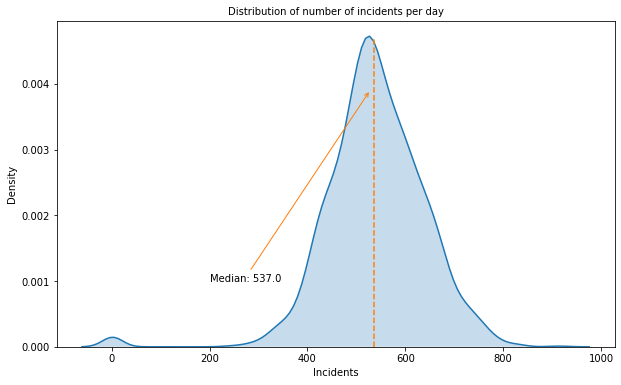

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

col = sns.color_palette()

plt.figure(figsize=(10, 6))
data = train.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])
plt.annotate(
    'Median: ' + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.001),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 10})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

In [16]:
train.dtypes

Unnamed: 0                       int64
Case Number                     object
Date                            object
Block                           object
IUCR                            object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
Dates                   datetime64[ns]
Hour                             int64
Primary Type                    object
dtype: object

In [26]:
train_data = train
train_data['DayOfWeek'] = train_data['Dates'].dt.weekday_name


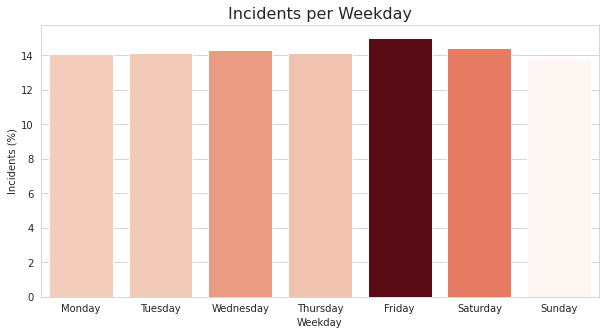

In [18]:
from matplotlib import cm

data = train.groupby('DayOfWeek').count().iloc[:, 0]
data = data.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        data.index, (data.values / data.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Reds').to_rgba(data.values))

plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Incidents (%)')

plt.show()

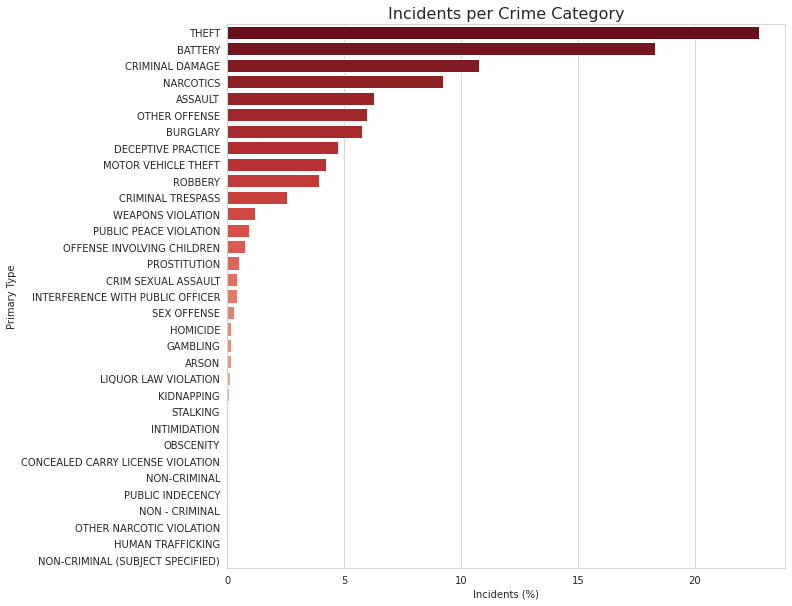

<Figure size 432x288 with 0 Axes>

In [40]:
data = train.groupby('Primary Type').count().iloc[:, 0].sort_values(
    ascending=False)
#data = data.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (data.values / data.values.sum()) * 100,
        data.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()
plt.savefig('fig1.png', dpi=300)

Heat map over cooridantes of crimes


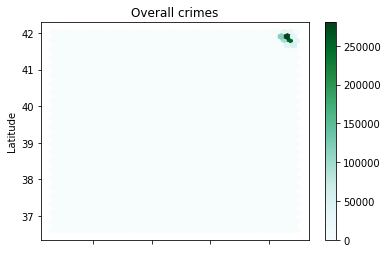

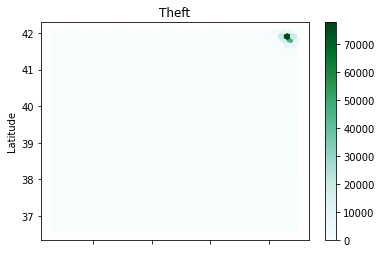

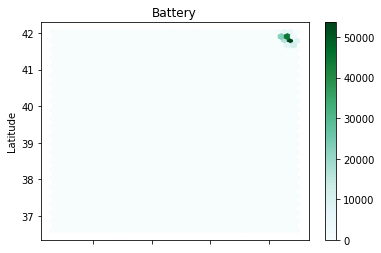

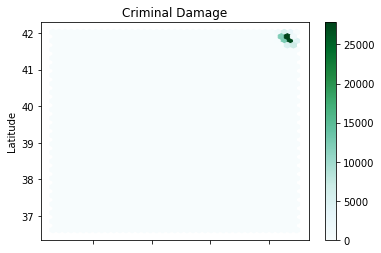

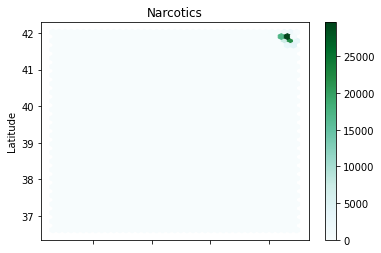

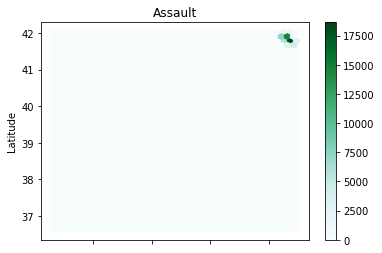

In [43]:
x = train
x_theft = x[x['Primary Type'] == "THEFT"]
x_battery = x[x['Primary Type'] == "BATTERY"]
x_cd = x[x['Primary Type'] == "CRIMINAL DAMAGE"]
x_narc = x[(x['Primary Type'] == "NARCOTICS")]
x_assault = x[(x['Primary Type'] == "ASSAULT")]

print("Heat map over cooridantes of crimes")
x.plot.hexbin(x='Longitude', y='Latitude', gridsize=40)
plt.title("Overall crimes")
plt.show()

x_theft.plot.hexbin(x='Longitude', y='Latitude', gridsize=40)
plt.title("Theft")

x_battery.plot.hexbin(x='Longitude', y='Latitude', gridsize=40)
plt.title("Battery")

x_cd.plot.hexbin(x='Longitude', y='Latitude', gridsize=40)
plt.title("Criminal Damage")
plt.show()

x_narc.plot.hexbin(x='Longitude', y='Latitude', gridsize=40)
plt.title("Narcotics")
plt.show()

x_assault.plot.hexbin(x='Longitude', y='Latitude', gridsize=40)
plt.title("Assault")
plt.show()


In [39]:
pd_districts = gpd.read_file('./chicago_geo.shp')
pd_districts.crs={'init': 'epsg:4326'}
pd_districts = pd_districts.merge(
    train.groupby('Community Area').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_index = True,
    right_index=True,
    suffixes=('_x', '_y'))
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})
train_days = train.groupby('Date').count().shape[0]

pd_districts['inc_per_day'] = pd_districts.Incidents/train_days
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()

AttributeError: 'GeoDataFrame' object has no attribute 'Incidents'

In [36]:
pd_districts

,geometry
0,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
...,...
72,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


In [20]:
naive_vals = train.groupby('Primary Type').count().iloc[:,0]/train.shape[0]
n_rows = test.shape[0]
print(n_rows)

submission = pd.DataFrame(
    np.repeat(np.array(naive_vals), n_rows).reshape(-1, n_rows).transpose(),
    columns=naive_vals.index)
submission.shape

425510


(425510, 33)

In [21]:
def feature_engineering(data):
    datas = pd.DataFrame()
    datas['n_days'] = (
        data['Date'] - data['Date'].min()).apply(lambda x: x.days)
    datas['Day'] = data['Dates'].dt.day
    datas['DayOfWeek'] = data['Dates'].dt.weekday
    datas['Month'] = data['Dates'].dt.month
    datas['Year'] = data['Dates'].dt.year
    datas['Hour'] = data['Dates'].dt.hour
    datas['Minute'] = data['Dates'].dt.minute
    datas['Block'] = data['Block'].str.contains('XX',case=True)
    datas['X'] = data['Longitude']
    datas['Y'] = data['Latitude']
    datas['category'] = data['Primary Type']
    datas['PdDistrict'] = data['Community Area']
        
    return datas

In [22]:
train = feature_engineering(train)
#train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)
train.head()

,n_days,Day,DayOfWeek,Month,Year,Hour,Minute,Block,X,Y,category,PdDistrict
ID,,,,,,,,,,,,
10760266,1786,21,0,11,2016,14,15,True,-87.701257,41.798372,THEFT,63.0
10374250,1469,9,5,1,2016,14,0,True,-87.679792,41.776731,MOTOR VEHICLE THEFT,66.0
9852939,1044,10,0,11,2014,10,55,True,-87.724364,41.877104,NARCOTICS,26.0
9265640,593,16,4,8,2013,11,35,True,-87.603216,41.736670,ASSAULT,44.0
10566971,1629,17,4,6,2016,7,0,True,-87.662707,41.881524,THEFT,28.0


In [ ]:
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])
le2 = LabelEncoder()
y = le2.fit_transform(train.pop('category'))

train_X, val_X, train_y, val_y = train_test_split(train, y)

model =LGBMClassifier(objective='multiclass', num_class=33).fit(train_X, train_y)

perm = PermutationImportance(model).fit(val_X, val_y)
eli5.show_weights(perm, feature_names=val_X.columns.tolist())